In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
def dtype_compressor(df):
  #object 
  # when unique ratio > 0.5, catogory stands less memory than object
  converted_obj = pd.DataFrame()
  df_obj = df.select_dtypes(include=['object'])
  for col in df_obj.columns:
    converted_obj.loc[:,col] = df_obj.loc[:,col].astype('category')

  # numbers
  df_down_num = pd.DataFrame()
  df_num = df.select_dtypes(include=['number'])
  for col in df_num.columns:
    df_down_num.loc[:,col] = pd.to_numeric(df_num.loc[:,col],downcast='signed')

  # merge
  df = pd.concat([converted_obj,df_down_num],axis=1)
  
  del converted_obj, df_obj, df_down_num, df_num  
  
  return df

In [3]:
def fast_datetime(s):
    dates = {date:pd.to_datetime(date,format='%Y%m%d') for date in s.unique()}
    return s.map(dates)

In [4]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

---

In [5]:
# 讀取train+members
KKboxTrainMembers = pd.read_csv('KKboxTrainMembers.csv')

In [6]:
KKboxTrainMembers = KKboxTrainMembers[KKboxTrainMembers['bd'] > 10]

In [7]:
KKboxTrainMembers.head()

,msno,is_churn,city,bd,gender,registered_via,registration_init_time
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5.000,28.000,1.000,3.000,2013-12-23
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,13.000,20.000,1.000,3.000,2013-12-23
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,13.000,18.000,1.000,3.000,2013-12-27
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,13.000,35.000,0.000,7.000,2014-01-25
7,moRTKhKIDvb+C8ZHOgmaF4dXMLk0jOn65d7a8tQ2Eds=,1,9.000,28.000,0.000,3.000,2014-02-02


---

## 資料探勘—關聯性分析

### 根據交易資料取得不同方案做關聯性分析-依詳細方案(含價格)製作欄位

In [8]:
# 讀取資料
ProgramTransac2nd_v1 = pd.read_csv('ProgramTransaction2nd_v1.csv')
ProgramTransac2nd_v2 = pd.read_csv('ProgramTransaction2nd_v2.csv')
# 合併兩份資料
ProgramTransac2nd = pd.concat([ProgramTransac2nd_v1, ProgramTransac2nd_v2], axis=0)
# 合併相同msno
ProgramTransac2nd = ProgramTransac2nd[['msno', 'Program_A_0days', 'Program_B_7days', 'Program_C_30days_month', 'Program_D_30days_acount', 'Program_E_90days', 'Program_F_90days_discount', 'Program_G_100days_card', 'Program_H_120days_season', 'Program_I_halfyear', 'Program_J_180days_discount', 'Program_K_200days_card', 'Program_L_360days_year', 'Program_M_395days', 'Program_N_410days_discount', 'Program_O_450days']].groupby(by=['msno'],as_index=False).sum()

In [9]:
# 重新命名
program_name = {'Program_A_0days':'A_0days', 'Program_B_7days':'B_7days',\
                'Program_C_30days_month':'C_30days_month', \
                'Program_D_30days_acount':'D_30days_acount',\
                'Program_E_90days':'E_90days',\
                'Program_F_90days_discount':'F_90days_discount',\
                'Program_G_100days_card':'G_100days_card',\
                'Program_H_120days_season':'H_120days_season',\
                'Program_I_halfyear':'I_halfyear',\
                'Program_J_180days_discount':'J_180days_discount',\
                'Program_K_200days_card':'K_200days_card',\
                'Program_L_360days_year':'L_360days_year',\
                'Program_M_395days':'M_395days',\
                'Program_N_410days_discount':'N_410days_discount', 'Program_O_450days':'O_450days'}
ProgramTransac2nd.rename(columns=program_name,inplace=True)

In [10]:
# 針對使用過方案的人都當作1，沒有的人當作0
ProgramTransac2nd_Col = list(ProgramTransac2nd.columns[1:])
for i in ProgramTransac2nd_Col:
    ProgramTransac2nd[i] = ProgramTransac2nd[i].apply(lambda x: 1 if x > 0 else 0)

In [11]:
# 合併用戶資料
KKboxMembersProgram2nd = pd.merge(KKboxTrainMembers, ProgramTransac2nd, how='left', on=['msno'])

##### 針對流失非流失進行隨機抽樣使得數據不平衡現象達到解決

In [12]:
def imbalance_random_sampling(df):
    # 取出特徵is_churn為流失(1)與非流失(0)的數據集
    df_notchurn = df[df['is_churn'] == 0]
    df_churn = df[df['is_churn'] == 1]
    # 因為要對數據量較多的一方進行隨機抽樣(這邊是notchurn數據量較多，並取得與churn數據量差不多的n)
    df_notchurn_change = df_notchurn.sample(n=52000)
    # 合併churn與notchurn欄位
    df_after = pd.concat([df_churn, df_notchurn_change], axis=0)
    df_after.sort_values(by=['msno','registration_init_time'],inplace=True)
    return df_after

In [13]:
KKboxMembersProgram2nd = imbalance_random_sampling(KKboxMembersProgram2nd)

In [14]:
print(KKboxMembersProgram2nd.shape)
KKboxMembersProgram2nd.head()

(103378, 22)


,msno,is_churn,city,bd,gender,registered_via,registration_init_time,A_0days,B_7days,C_30days_month,...,F_90days_discount,G_100days_card,H_120days_season,I_halfyear,J_180days_discount,K_200days_card,L_360days_year,M_395days,N_410days_discount,O_450days
173358,++0nOC7BmrUTtcSboRORfg6ZXTajnBDt1f/SEgH6ONo=,0,13.000,25.000,1.000,9.000,2010-02-03,0,0,1,...,0,0,0,0,1,0,0,0,0,0
239969,++9JUsaZioofS6Fb20Z0z2QOlWNzakO0PRF5GZ75yi4=,1,13.000,22.000,1.000,9.000,2014-12-10,1,0,1,...,0,0,0,0,0,0,0,0,0,0
134710,++EcAZQCSSJQMx37/+/QqjiVQq3cS/hGug6JlzCufig=,0,4.000,28.000,1.000,9.000,2011-02-05,1,0,1,...,0,0,0,0,0,0,0,0,0,0
28091,++FM6zdGj2whewSf10HHTRTeg2/jnxq3NQJKeYmAKwY=,1,3.000,22.000,1.000,9.000,2015-01-21,1,0,1,...,0,0,0,1,0,0,0,0,0,0
190564,++FojTWzKjhz7uxsZXEN3KBpxSmSvPr2j9KEuLzVAm4=,0,13.000,23.000,1.000,3.000,2013-02-10,1,0,1,...,0,0,0,0,0,0,0,0,0,0


##### 套入其他交易特徵

In [75]:
KKboxMemTran = pd.read_csv('KKboxTrainMemTransac.csv')
KKboxMemTran = KKboxMemTran[['msno', 'last_last_churn','last_auto_renew', 'is_discount', \
                             'amount_per_day', 'longtime_user']]

In [76]:
KKboxMemTran.head()

,msno,last_last_churn,last_auto_renew,is_discount,amount_per_day,longtime_user
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,-1.000,0.000,1,4.967,0
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,0.000,0.000,2,6.000,0
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,0.000,0.000,4,3.317,0
3,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,0.000,1.000,5,3.300,1
4,moRTKhKIDvb+C8ZHOgmaF4dXMLk0jOn65d7a8tQ2Eds=,-1.000,0.000,1,4.361,0


In [100]:
KKboxProgram2ndFinal = pd.merge(KKboxMembersProgram2nd, KKboxMemTran, how='left', on=['msno'])

In [101]:
KKboxProgram2ndFinal.drop_duplicates(subset=None, keep='first', inplace=True)

In [102]:
print(KKboxProgram2ndFinal.shape)
KKboxProgram2ndFinal.head()

(103378, 27)


,msno,is_churn,city,bd,gender,registered_via,registration_init_time,A_0days,B_7days,C_30days_month,...,K_200days_card,L_360days_year,M_395days,N_410days_discount,O_450days,last_last_churn,last_auto_renew,is_discount,amount_per_day,longtime_user
0,++0nOC7BmrUTtcSboRORfg6ZXTajnBDt1f/SEgH6ONo=,0,13.000,25.000,1.000,9.000,2010-02-03,0,0,1,...,0,0,0,0,0,-1.000,1.000,1.000,4.967,0.000
1,++9JUsaZioofS6Fb20Z0z2QOlWNzakO0PRF5GZ75yi4=,1,13.000,22.000,1.000,9.000,2014-12-10,1,0,1,...,0,0,0,0,0,0.000,1.000,3.000,4.967,0.000
2,++EcAZQCSSJQMx37/+/QqjiVQq3cS/hGug6JlzCufig=,0,4.000,28.000,1.000,9.000,2011-02-05,1,0,1,...,0,0,0,0,0,0.000,1.000,3.000,4.967,0.000
3,++FM6zdGj2whewSf10HHTRTeg2/jnxq3NQJKeYmAKwY=,1,3.000,22.000,1.000,9.000,2015-01-21,1,0,1,...,0,0,0,0,0,-1.000,0.000,1.000,4.585,0.000
4,++FojTWzKjhz7uxsZXEN3KBpxSmSvPr2j9KEuLzVAm4=,0,13.000,23.000,1.000,3.000,2013-02-10,1,0,1,...,0,0,0,0,0,0.000,1.000,3.000,4.967,0.000


In [103]:
print(len(KKboxProgram2ndFinal[KKboxProgram2ndFinal['is_churn'] == 1]))
print(len(KKboxProgram2ndFinal[KKboxProgram2ndFinal['is_churn'] == 0]))

51378
52000


In [104]:
KKboxProgram2ndFinal['gender'] = KKboxProgram2ndFinal['gender'].fillna(-1)

In [105]:
KKboxProgram2ndFinal = KKboxProgram2ndFinal.dropna()

In [106]:
KKboxProgram2ndFinal.head()

,msno,is_churn,city,bd,gender,registered_via,registration_init_time,A_0days,B_7days,C_30days_month,...,K_200days_card,L_360days_year,M_395days,N_410days_discount,O_450days,last_last_churn,last_auto_renew,is_discount,amount_per_day,longtime_user
0,++0nOC7BmrUTtcSboRORfg6ZXTajnBDt1f/SEgH6ONo=,0,13.000,25.000,1.000,9.000,2010-02-03,0,0,1,...,0,0,0,0,0,-1.000,1.000,1.000,4.967,0.000
1,++9JUsaZioofS6Fb20Z0z2QOlWNzakO0PRF5GZ75yi4=,1,13.000,22.000,1.000,9.000,2014-12-10,1,0,1,...,0,0,0,0,0,0.000,1.000,3.000,4.967,0.000
2,++EcAZQCSSJQMx37/+/QqjiVQq3cS/hGug6JlzCufig=,0,4.000,28.000,1.000,9.000,2011-02-05,1,0,1,...,0,0,0,0,0,0.000,1.000,3.000,4.967,0.000
3,++FM6zdGj2whewSf10HHTRTeg2/jnxq3NQJKeYmAKwY=,1,3.000,22.000,1.000,9.000,2015-01-21,1,0,1,...,0,0,0,0,0,-1.000,0.000,1.000,4.585,0.000
4,++FojTWzKjhz7uxsZXEN3KBpxSmSvPr2j9KEuLzVAm4=,0,13.000,23.000,1.000,3.000,2013-02-10,1,0,1,...,0,0,0,0,0,0.000,1.000,3.000,4.967,0.000


In [86]:
kkboxdata2017 = pd.read_csv('kkboxdata2017.csv')

In [87]:
kkboxdata2017 = kkboxdata2017[['msno',"('num_25', 'mean')","('num_50', 'mean')",\
                               "('num_75', 'mean')", "('num_985', 'mean')","('num_100', 'mean')",\
                               "('num_unq', 'mean')","('total_secs', 'mean')",\
                               'play_days','payment_method_id_mode','payment_plan_days_mode',\
                               'is_auto_renew_sum','is_cancel_sum','transactions_times']]

In [107]:
KKboxProgram2ndFinal = pd.merge(KKboxProgram2ndFinal, kkboxdata2017, how='left', on=['msno'])

In [108]:
KKboxProgram2ndFinal.head()

,msno,is_churn,city,bd,gender,registered_via,registration_init_time,A_0days,B_7days,C_30days_month,...,"('num_985', 'mean')","('num_100', 'mean')","('num_unq', 'mean')","('total_secs', 'mean')",play_days,payment_method_id_mode,payment_plan_days_mode,is_auto_renew_sum,is_cancel_sum,transactions_times
0,++0nOC7BmrUTtcSboRORfg6ZXTajnBDt1f/SEgH6ONo=,0,13.000,25.000,1.000,9.000,2010-02-03,0,0,1,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,++9JUsaZioofS6Fb20Z0z2QOlWNzakO0PRF5GZ75yi4=,1,13.000,22.000,1.000,9.000,2014-12-10,1,0,1,...,0.250,37.250,34.179,9214.771,28.000,37.000,30.000,3.000,1.000,3.000
2,++EcAZQCSSJQMx37/+/QqjiVQq3cS/hGug6JlzCufig=,0,4.000,28.000,1.000,9.000,2011-02-05,1,0,1,...,0.641,11.487,12.872,3304.388,39.000,39.000,30.000,1.000,0.000,1.000
3,++FM6zdGj2whewSf10HHTRTeg2/jnxq3NQJKeYmAKwY=,1,3.000,22.000,1.000,9.000,2015-01-21,1,0,1,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,++FojTWzKjhz7uxsZXEN3KBpxSmSvPr2j9KEuLzVAm4=,0,13.000,23.000,1.000,3.000,2013-02-10,1,0,1,...,0.260,16.400,17.020,4091.231,50.000,37.000,30.000,2.000,0.000,2.000


In [110]:
# 針對缺失值處理-1
userlogmean_col = ["('num_25', 'mean')","('num_50', 'mean')","('num_75', 'mean')","('num_985', 'mean')","('num_100', 'mean')", "('num_unq', 'mean')","('total_secs', 'mean')",'play_days','is_auto_renew_sum','is_cancel_sum','transactions_times']
for i in userlogmean_col:
    KKboxProgram2ndFinal[i] = KKboxProgram2ndFinal[i].fillna(KKboxProgram2ndFinal[i].mean())
paymentmode_col = ['payment_method_id_mode', 'payment_plan_days_mode']
for k in paymentmode_col:
    KKboxProgram2ndFinal[k] = KKboxProgram2ndFinal[k].fillna(KKboxProgram2ndFinal[k].mode().iloc[0])

In [135]:
# 存成csv
KKboxProgram2ndFinal.to_csv('KKboxProgram3rdFinal_balance.csv',index=False,header=True)

---

## 從這邊開始看範例

---

## 切資料

### 以年齡26為分界分類

##### 讀資料

In [5]:
KKboxProgramFinal = pd.read_csv('KKboxProgram3rdFinal_balance.csv')

In [6]:
print(KKboxProgramFinal.shape)
KKboxProgramFinal.head()

(96434, 40)


,msno,is_churn,city,bd,gender,registered_via,registration_init_time,A_0days,B_7days,C_30days_month,...,"('num_985', 'mean')","('num_100', 'mean')","('num_unq', 'mean')","('total_secs', 'mean')",play_days,payment_method_id_mode,payment_plan_days_mode,is_auto_renew_sum,is_cancel_sum,transactions_times
0,++0nOC7BmrUTtcSboRORfg6ZXTajnBDt1f/SEgH6ONo=,0,13.000,25.000,1.000,9.000,2010-02-03,0,0,1,...,1.040,28.148,27.545,7370.222,35.889,40.000,30.000,1.459,0.064,1.860
1,++9JUsaZioofS6Fb20Z0z2QOlWNzakO0PRF5GZ75yi4=,1,13.000,22.000,1.000,9.000,2014-12-10,1,0,1,...,0.250,37.250,34.179,9214.771,28.000,37.000,30.000,3.000,1.000,3.000
2,++EcAZQCSSJQMx37/+/QqjiVQq3cS/hGug6JlzCufig=,0,4.000,28.000,1.000,9.000,2011-02-05,1,0,1,...,0.641,11.487,12.872,3304.388,39.000,39.000,30.000,1.000,0.000,1.000
3,++FM6zdGj2whewSf10HHTRTeg2/jnxq3NQJKeYmAKwY=,1,3.000,22.000,1.000,9.000,2015-01-21,1,0,1,...,1.040,28.148,27.545,7370.222,35.889,40.000,30.000,1.459,0.064,1.860
4,++FojTWzKjhz7uxsZXEN3KBpxSmSvPr2j9KEuLzVAm4=,0,13.000,23.000,1.000,3.000,2013-02-10,1,0,1,...,0.260,16.400,17.020,4091.231,50.000,37.000,30.000,2.000,0.000,2.000


In [7]:
KKboxProgramFinal['last_last_churn'].unique()

array([-1.,  0.,  1.])

##### 分割

In [8]:
# 用年齡26歲作分割(若要分不同群，再多加欄位即可)
df_Under26 = KKboxProgramFinal[KKboxProgramFinal['bd'] < 26]
df_Above26 = KKboxProgramFinal[KKboxProgramFinal['bd'] >= 26]
# 加入id，可自行取名(改單引號內為自己可以辨識的id即可)
df_Above26.insert(0, 'id', 'Group_Above26')
df_Under26.insert(0, 'id', 'Group_Under26')
# 取要用到的欄位(這邊不用改)
GroupProgram2ndCol = ['id', 'is_churn', 'A_0days', 'B_7days',\
                          'C_30days_month', 'D_30days_acount', 'E_90days',\
                          'F_90days_discount', 'G_100days_card',\
                          'H_120days_season', 'I_halfyear',\
                          'J_180days_discount', 'K_200days_card',\
                          'L_360days_year', 'M_395days',\
                          'N_410days_discount', 'O_450days']
# 合併每群的方案數量
Above26_2nd = df_Above26[GroupProgram2ndCol].groupby(by=['id'],as_index=False).sum()
Under26_2nd = df_Under26[GroupProgram2ndCol].groupby(by=['id'],as_index=False).sum()

##### 確認分群數量是否均衡?(差異太多直接重新分群)

In [9]:
print(len(df_Above26))
print(len(df_Under26))

57470
38964


##### 確認各群流失/未流失比例?(如果要做關聯性與各群流失關係的話，最好在不同群的流失比例有顯著差異)

In [21]:
# 確認第一群(Above26)流失/未流失比例
print('第一群(Above26)流失/未流失比例:')
print('流失所佔比例:{:.2f}%'.format(100*(len(df_Above26[df_Above26['is_churn'] == 1]) / len(df_Above26))))
# print('未流失所佔比例:{:.2f}%'.format(100*(len(df_Above26[df_Above26['is_churn'] == 0]) / len(df_Above26))))
# 確認第二群(Under26)流失/未流失比例
print('第二群(Under26)流失/未流失比例:')
print('流失所佔比例:{:.2f}%'.format(100*(len(df_Under26[df_Under26['is_churn'] == 1]) / len(df_Under26))))
# print('未流失所佔比例:{:.2f}%'.format(100*(len(df_Under26[df_Under26['is_churn'] == 0]) / len(df_Under26))))

第一群(Above26)流失/未流失比例:
流失所佔比例:39.42%
第二群(Under26)流失/未流失比例:
流失所佔比例:56.26%


##### 分成不同群結果：

In [11]:
CutbyAge26_2nd = pd.concat([Above26_2nd, Under26_2nd], axis=0)
CutbyAge26_2nd.reset_index(inplace=True)
CutbyAge26_2nd = CutbyAge26_2nd.drop(columns='index')
CutbyAge26_2nd = CutbyAge26_2nd.set_index('id')
CutbyAge26_2nd.head()

,is_churn,A_0days,B_7days,C_30days_month,D_30days_acount,E_90days,F_90days_discount,G_100days_card,H_120days_season,I_halfyear,J_180days_discount,K_200days_card,L_360days_year,M_395days,N_410days_discount,O_450days
id,,,,,,,,,,,,,,,,
Group_Above26,22657,26197,3043,43497,6707,427,493,329,165,3043,2238,115,140,187,3974,84
Group_Under26,21920,9532,5464,29353,2964,1176,582,1004,641,3506,339,296,1223,82,2355,15


In [12]:
CutbyAge26_2nd

,is_churn,A_0days,B_7days,C_30days_month,D_30days_acount,E_90days,F_90days_discount,G_100days_card,H_120days_season,I_halfyear,J_180days_discount,K_200days_card,L_360days_year,M_395days,N_410days_discount,O_450days
id,,,,,,,,,,,,,,,,
Group_Above26,22657,26197,3043,43497,6707,427,493,329,165,3043,2238,115,140,187,3974,84
Group_Under26,21920,9532,5464,29353,2964,1176,582,1004,641,3506,339,296,1223,82,2355,15


##### 換算各方案佔不同群之比例(比例越大越好)

In [13]:
# 對於不同群做比例換算並新增欄位(依照不同群可新增，此處為兩群故分兩欄位)
# CutbyAge26_2nd.loc['新欄位名稱'] = CutbyAge26_2nd.loc['要算比例的欄位名稱'] / (加總)
CutbyAge26_2nd.loc['Group_Above26_Ratio'] = CutbyAge26_2nd.loc['Group_Above26'] / (CutbyAge26_2nd.loc['Group_Above26'] + CutbyAge26_2nd.loc['Group_Under26'])
CutbyAge26_2nd.loc['Group_Under26_Ratio'] = CutbyAge26_2nd.loc['Group_Under26'] / (CutbyAge26_2nd.loc['Group_Above26'] + CutbyAge26_2nd.loc['Group_Under26'])
# 僅顯示含比例欄位
CutbyAge26_2nd = CutbyAge26_2nd.loc[['Group_Above26_Ratio', 'Group_Under26_Ratio']]
CutbyAge26_2nd.head()

,is_churn,A_0days,B_7days,C_30days_month,D_30days_acount,E_90days,F_90days_discount,G_100days_card,H_120days_season,I_halfyear,J_180days_discount,K_200days_card,L_360days_year,M_395days,N_410days_discount,O_450days
id,,,,,,,,,,,,,,,,
Group_Above26_Ratio,0.508,0.733,0.358,0.597,0.694,0.266,0.459,0.247,0.205,0.465,0.868,0.280,0.103,0.695,0.628,0.848
Group_Under26_Ratio,0.492,0.267,0.642,0.403,0.306,0.734,0.541,0.753,0.795,0.535,0.132,0.720,0.897,0.305,0.372,0.152


##### 製造rattle()用的csv

In [57]:
df_rattle = pd.DataFrame(columns=['id', 'Project'])
num = 0
for n, m in enumerate(list(CutbyAge26_2nd.index)):
    for i, k in enumerate(list(CutbyAge26_2nd.columns[1:])):
        if CutbyAge26_2nd.loc[m,k] >= 0.7:
            df_rattle = df_rattle.append({'id':m, 'Project':k}, ignore_index=True)

In [58]:
df_rattle

,id,Project
0,Group_Above26_Ratio,A_0days
1,Group_Above26_Ratio,J_180days_discount
2,Group_Above26_Ratio,O_450days
3,Group_Under26_Ratio,E_90days
4,Group_Under26_Ratio,G_100days_card
5,Group_Under26_Ratio,H_120days_season
6,Group_Under26_Ratio,K_200days_card
7,Group_Under26_Ratio,L_360days_year


In [20]:
# 存成可以放在rattle中分析的csv(自行改名)
df_rattle.to_csv('CutByAge26_3rd_forRattle.csv',index=False,header=True)

---

### 有故事的的關聯分析分群存成csv，並分別拿來跑各種模型(決策樹、xgboost等等)看看

In [17]:
print(df_Above26.shape)
df_Above26 = df_Above26.dropna()
df_Above26.head()

(57470, 41)


,id,msno,is_churn,city,bd,gender,registered_via,registration_init_time,A_0days,B_7days,...,"('num_985', 'mean')","('num_100', 'mean')","('num_unq', 'mean')","('total_secs', 'mean')",play_days,payment_method_id_mode,payment_plan_days_mode,is_auto_renew_sum,is_cancel_sum,transactions_times
2,Group_Above26,++EcAZQCSSJQMx37/+/QqjiVQq3cS/hGug6JlzCufig=,0,4.000,28.000,1.000,9.000,2011-02-05,1,0,...,0.641,11.487,12.872,3304.388,39.000,39.000,30.000,1.000,0.000,1.000
6,Group_Above26,++N9C3T2DFC2uRZ9LYOJW0KSq1sG++54neJYETDmkkI=,0,5.000,29.000,1.000,3.000,2014-11-05,0,1,...,2.965,32.807,33.421,9351.400,57.000,38.000,30.000,0.000,0.000,2.000
7,Group_Above26,++OO0dlx66sqqbXfJu9K4tX94zYLNwN/kq0cMOCVDyQ=,1,17.000,30.000,1.000,4.000,2016-10-25,0,0,...,0.571,30.571,19.714,7944.478,7.000,29.000,30.000,0.000,0.000,2.000
8,Group_Above26,++Tp41swlnwrt2eLTL1cSAn97YgfRVh3uG9VHEmAySA=,1,13.000,36.000,1.000,3.000,2015-06-02,0,1,...,1.434,22.245,28.981,6149.943,53.000,38.000,30.000,0.000,0.000,2.000
9,Group_Above26,++Ve6PtJ8HDzBYbkuwGkmNrXdOk7ZLfTATtE6G/mX/U=,0,5.000,45.000,0.000,9.000,2008-03-23,1,0,...,0.667,21.444,24.611,5912.379,18.000,34.000,30.000,2.000,0.000,2.000


In [18]:
print(df_Under26.shape)
df_Under26.head()

(38964, 41)


,id,msno,is_churn,city,bd,gender,registered_via,registration_init_time,A_0days,B_7days,...,"('num_985', 'mean')","('num_100', 'mean')","('num_unq', 'mean')","('total_secs', 'mean')",play_days,payment_method_id_mode,payment_plan_days_mode,is_auto_renew_sum,is_cancel_sum,transactions_times
0,Group_Under26,++0nOC7BmrUTtcSboRORfg6ZXTajnBDt1f/SEgH6ONo=,0,13.000,25.000,1.000,9.000,2010-02-03,0,0,...,1.040,28.148,27.545,7370.222,35.889,40.000,30.000,1.459,0.064,1.860
1,Group_Under26,++9JUsaZioofS6Fb20Z0z2QOlWNzakO0PRF5GZ75yi4=,1,13.000,22.000,1.000,9.000,2014-12-10,1,0,...,0.250,37.250,34.179,9214.771,28.000,37.000,30.000,3.000,1.000,3.000
3,Group_Under26,++FM6zdGj2whewSf10HHTRTeg2/jnxq3NQJKeYmAKwY=,1,3.000,22.000,1.000,9.000,2015-01-21,1,0,...,1.040,28.148,27.545,7370.222,35.889,40.000,30.000,1.459,0.064,1.860
4,Group_Under26,++FojTWzKjhz7uxsZXEN3KBpxSmSvPr2j9KEuLzVAm4=,0,13.000,23.000,1.000,3.000,2013-02-10,1,0,...,0.260,16.400,17.020,4091.231,50.000,37.000,30.000,2.000,0.000,2.000
5,Group_Under26,++GeSFVX+57LLP1FT1EQ5uUWgP03beR/Bzh52e6Rd3E=,0,14.000,25.000,1.000,9.000,2014-12-21,0,0,...,0.610,28.780,25.537,7481.450,41.000,40.000,30.000,2.000,0.000,2.000


In [19]:
# 存成csv
df_Above26.to_csv('Cut_Above26_forModel.csv',index=False,header=True)
df_Under26.to_csv('Cut_Under26_forModel.csv',index=False,header=True)

---

## 結果分析:

##### 方案關聯分析：

|群別|關聯方案|群體內流失率|
|--|--|--|
|26歲以上使用裝置9用戶|180天信用卡方案,450天方案|36.9%|
|26歲以下使用裝置3用戶|100天實體儲值卡,200天實體儲值卡,年費方案|61.0%|

##### 第一層(以年齡分群):確認26歲以上與26歲以下兩群體比較:

|特徵|26歲以上|26歲以下|
|--|--|--|
|is_churn(流失率)|39.4%|56.3%|
|last_last_churn(前次續訂)|86.1%|80.6%|
|last_auto_renew(前次自動續訂)|76.4%|45.9%|
|is_discount(得到平均折扣數)|2.72次|2.53次|
|amount_per_day(平均每日方案花費)|4.84元|4.74元|
|registered_via(使用裝置9)|57.4%|37.9%|
|registered_via(使用裝置3)|19.3%|34.7%|
|聽歌未達25%長度數量|5.27首|6.55首|
|聽歌未達50%長度數量|1.33首|1.66首|
|聽歌未達75%長度數量|0.84首|1.01首|
|聽歌達98.5%長度數量|0.97首|1.15首|
|整首歌聽完數量|28.4首|27.8首|
|關聯方案|180天信用卡方案,450天方案|100天實體卡,200天實體卡,年費方案|

##### 第二層:進一步確認兩群分別使用26歲以上裝置9與26歲以下裝置3的流失率以及特徵

    
|特徵|26歲以上使用裝置9|26歲以下使用裝置3|
|--|--|--|
|is_churn(流失率)|36.9%|61.0%|
|last_last_churn(前次續訂)|85.9%|76.8%|
|last_auto_renew(前次自動續訂)|77.8%|36.9%|
|is_discount(得到平均折扣數)|2.71次|2.41次|
|amount_per_day(平均每日方案花費)|4.95元|4.91元|
|聽歌未達25%長度數量|5.24首|6.55首|
|聽歌未達50%長度數量|1.33首|1.66首|
|聽歌未達75%長度數量|0.84首|1.01首|
|聽歌達98.5%長度數量|0.97首|1.13首|
|整首歌聽完數量|28.4首|27.8首|
|關聯方案|180天信用卡方案,450天方案|100天實體卡,200天實體卡,年費方案|

##### 26歲以上用戶  vs 26歲以下用戶
<table>
<td> 
<img src="https://github.com/imiKao/KKBoxProject_for_TcfstCourse/blob/master/Images/CutByAge26/%E8%B7%91Model/NEW/Above26_Tree.png?raw=true">
</td> 
<td> 
<img src="https://github.com/imiKao/KKBoxProject_for_TcfstCourse/blob/master/Images/CutByAge26/%E8%B7%91Model/NEW/Under26_Tree.png?raw=true">
</td> 
</table>
<caption><center> 26歲以上 vs 26歲以下 </center></caption>

##### 26歲以上使用裝置9用戶 vs 26歲以下使用裝置3用戶
<table>
<td> 
<img src="https://github.com/imiKao/KKBoxProject_for_TcfstCourse/blob/master/Images/CutByAge26/%E8%B7%91Model/NEW/Above26_Device9_Tree1.png?raw=true">
</td> 
<td> 
<img src="https://github.com/imiKao/KKBoxProject_for_TcfstCourse/blob/master/Images/CutByAge26/%E8%B7%91Model/NEW/Above26_Device9_Tree2.png?raw=true">
</td> 
<td> 
<img src="https://github.com/imiKao/KKBoxProject_for_TcfstCourse/blob/master/Images/CutByAge26/%E8%B7%91Model/NEW/Above26_Device9_Tree3.png?raw=true">
</td> 
</table>
<caption><center> 26歲以上使用裝置9用戶 </center></caption>

<table>
<td> 
<img src="https://github.com/imiKao/KKBoxProject_for_TcfstCourse/blob/master/Images/CutByAge26/%E8%B7%91Model/NEW/Under26_Device3_Tree1.png?raw=true">
</td> 
<td> 
<img src="https://github.com/imiKao/KKBoxProject_for_TcfstCourse/blob/master/Images/CutByAge26/%E8%B7%91Model/NEW/Under26_Device3_Tree2.png?raw=true">
</td> 
<td> 
<img src="https://github.com/imiKao/KKBoxProject_for_TcfstCourse/blob/master/Images/CutByAge26/%E8%B7%91Model/NEW/Under26_Device3_Tree3.png?raw=true">
</td> 
</table>
<caption><center> 26歲以下使用裝置3用戶 </center></caption>

#### 小結:
* 此次分析對用戶個人特徵以兩層深度進行關聯分析:
* 第一層:年齡(26歲(含)以上 vs 26歲以下):
> * 分群依據:
>> * 26歲大約介於大學、研究所畢業至職場新人期為區間
>> * 根據年齡資料分布，切割點為峰值區間
> * 結果分析(使用決策樹分析觀察影響流失關鍵因子)
>> * 影響26歲以上用戶關鍵因子有「獲得折扣次數」、「手動取消的行為」兩項
>> * 影響26歲以下用戶關鍵因子有「獲得折扣次數」、「手動取消的行為」與「自動續約次數」三項。
>> * 關鍵因子「獲得折扣次數」
> * 關聯分析(以不同方案比較兩族群差異):26歲以上(180天信用卡方案,450天方案) vs 26歲以下(100天實體卡,200天實體卡,年費方案)
* 加入第二層用戶特徵:裝置(裝置3 vs 裝置9):
> * 分群依據:群體26歲以上明顯偏好使用裝置9(相較其他裝置)，群體26歲以下較常使用裝置3與裝置9。
> * 結果分析:
>> * 加入第二層分群(裝置3 vs 裝置9)後，可得出「26歲以上使用裝置9 vs 26歲以下使用裝置3」流失率差異最大。主要差異除了特徵「last_auto_renew(前次自動續約)」以外，特徵「裝置3」在26歲以下族群使用率較高也可能使得流失率差異影響。(後續如果能夠獲得裝置詳細資訊可進一步討論)
>> * 影響26歲以上使用裝置9的用戶關鍵因子有「獲得折扣次數」、「手動取消的行為」、「前次是否自動續約」與「使用方案的平均每日花費」四項因子。
>> * 影響26歲以下使用裝置3的用戶關鍵因子有「獲得折扣次數」、「使用方案的平均每日花費」、「自動續約次數」、「前次是否自動續約」與「非連續使用的使用者」五項因子。

##### 結果整理

|群體|流失率低用戶|流失率高用戶|
|--|--|--|
|流失率|36.9%|61.0%|
|關聯方案|180天信用卡方案,450天方案	|100天實體卡,200天實體卡,年費方案|
|影響流失關鍵因子|「獲得折扣次數」、「使用方案的平均每日花費」、「手動取消的行為」、「前次是否自動續約」|「獲得折扣次數」、「使用方案的平均每日花費」、「自動續約次數」、「前次是否自動續約」、「非連續使用的使用者」|

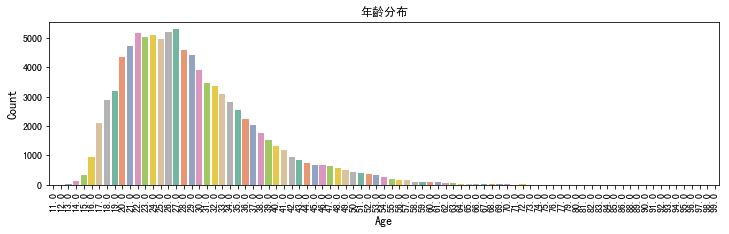

In [119]:
plt.figure(figsize=(12,3))
sns.countplot(x="bd", data=KKboxProgramFinal , palette = "Set2")
plt.ylabel('Count', fontsize=12)
plt.xlabel('Age', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("年齡分布", fontsize=12)
plt.show()

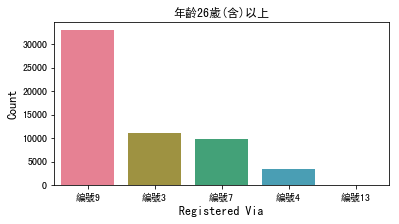

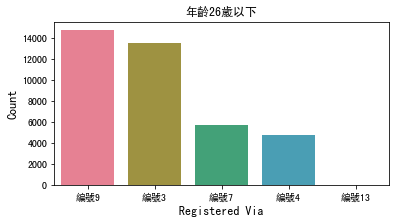

In [125]:
plt.figure(figsize=(6,3))
R_V_order = df_Above26['registered_via'].unique()
sns.countplot(x="registered_via", data=df_Above26, order=df_Above26["registered_via"].value_counts().index, palette = "husl")
plt.ylabel('Count', fontsize=12)
plt.xlabel('Registered Via', fontsize=12)
plt.xticks(np.arange(5), ('編號9', '編號3', '編號7', '編號4', '編號13'))
plt.title("年齡26歲(含)以上", fontsize=12)
plt.show()

plt.figure(figsize=(6,3))
R_V_order = df_Under26['registered_via'].unique()
sns.countplot(x="registered_via", data=df_Under26, order=df_Under26["registered_via"].value_counts().index, palette = "husl")
plt.ylabel('Count', fontsize=12)
plt.xlabel('Registered Via', fontsize=12)
plt.xticks(np.arange(5), ('編號9', '編號3', '編號7', '編號4', '編號13'))
plt.title("年齡26歲以下", fontsize=12)
plt.show()

---

In [36]:
df_Above26_device9 = df_Above26[df_Above26['registered_via'] == 9]
df_Above26_device3 = df_Above26[df_Above26['registered_via'] == 3]
df_Under26_device9 = df_Under26[df_Under26['registered_via'] == 9]
df_Under26_device3 = df_Under26[df_Under26['registered_via'] == 3]

In [37]:
# 細分成四群後流失率
print('流失率={:.1f}%'.format(100*len(df_Above26_device9[df_Above26_device9['is_churn'] == 1]) / len(df_Above26_device9)))
print('流失率={:.1f}%'.format(100*len(df_Above26_device3[df_Above26_device3['is_churn'] == 1]) / len(df_Above26_device3)))
print('流失率={:.1f}%'.format(100*len(df_Under26_device9[df_Under26_device9['is_churn'] == 1]) / len(df_Under26_device9)))
print('流失率={:.1f}%'.format(100*len(df_Under26_device3[df_Under26_device3['is_churn'] == 1]) / len(df_Under26_device3)))

流失率=36.9%
流失率=46.5%
流失率=56.4%
流失率=61.0%


In [38]:
# 存成csv
df_Above26_device9.to_csv('df_Above26_device9.csv',index=False,header=True)
df_Above26_device3.to_csv('df_Above26_device3.csv',index=False,header=True)
df_Under26_device9.to_csv('df_Under26_device9.csv',index=False,header=True)
df_Under26_device3.to_csv('df_Under26_device3.csv',index=False,header=True)

---

##### 關聯分析各種方案說明

|方案|方案說明|
|-|-|
|A_0days|	0天，目前尚未確認是什麼方案，但筆數眾多，因此沒有刪掉|
|B_7days|	短期體驗方案|
|C_30days_month	|月租方案|
|D_30days_acount|月租優惠方案|
|E_90days|	90天方案|
|F_90days_discount	|90天優惠方案|
|G_100days_card	|100天實體儲值卡|
|H_120days_season	|120天季卡|
|I_halfyear	|半年方案|
|J_180days_discount	|180天信用卡方案|
|K_200days_card	|200天實體儲值卡|
|L_360days_year	|年費方案|
|M_395days	|395天方案|
|N_410days_discount	|365天限時加送方案|
|O_450days|450天方案|

---

##### 方案關聯分析：

|群別|關聯方案|
|--|--|
|流失族群|半年方案,180天信用卡方案,365天限時加送方案,395天方案|
|非流失族群|月租優惠方案|


In [174]:
df_churn.head()

,id,msno,is_churn,city,bd,gender,registered_via,registration_init_time,A_0days,B_7days,...,"('num_985', 'mean')","('num_100', 'mean')","('num_unq', 'mean')","('total_secs', 'mean')",play_days,payment_method_id_mode,payment_plan_days_mode,is_auto_renew_sum,is_cancel_sum,transactions_times
1,Churn,++9JUsaZioofS6Fb20Z0z2QOlWNzakO0PRF5GZ75yi4=,1,13.000,22.000,1.000,9.000,2014-12-10,1,0,...,0.250,37.250,34.179,9214.771,28.000,37.000,30.000,3.000,1.000,3.000
3,Churn,++FM6zdGj2whewSf10HHTRTeg2/jnxq3NQJKeYmAKwY=,1,3.000,22.000,1.000,9.000,2015-01-21,1,0,...,1.040,28.148,27.545,7370.222,35.889,40.000,30.000,1.459,0.064,1.860
7,Churn,++OO0dlx66sqqbXfJu9K4tX94zYLNwN/kq0cMOCVDyQ=,1,17.000,30.000,1.000,4.000,2016-10-25,0,0,...,0.571,30.571,19.714,7944.478,7.000,29.000,30.000,0.000,0.000,2.000
8,Churn,++Tp41swlnwrt2eLTL1cSAn97YgfRVh3uG9VHEmAySA=,1,13.000,36.000,1.000,3.000,2015-06-02,0,1,...,1.434,22.245,28.981,6149.943,53.000,38.000,30.000,0.000,0.000,2.000
10,Churn,++h+LbvuDVdQ4qf2XXCuR651W1sy5hvGPbyN7q7RwuA=,1,15.000,19.000,0.000,3.000,2015-10-04,0,0,...,1.040,28.148,27.545,7370.222,35.889,40.000,30.000,1.459,0.064,1.860


In [175]:
df_notchurn.head()

,id,msno,is_churn,city,bd,gender,registered_via,registration_init_time,A_0days,B_7days,...,"('num_985', 'mean')","('num_100', 'mean')","('num_unq', 'mean')","('total_secs', 'mean')",play_days,payment_method_id_mode,payment_plan_days_mode,is_auto_renew_sum,is_cancel_sum,transactions_times
0,NotChurn,++0nOC7BmrUTtcSboRORfg6ZXTajnBDt1f/SEgH6ONo=,0,13.000,25.000,1.000,9.000,2010-02-03,0,0,...,1.040,28.148,27.545,7370.222,35.889,40.000,30.000,1.459,0.064,1.860
2,NotChurn,++EcAZQCSSJQMx37/+/QqjiVQq3cS/hGug6JlzCufig=,0,4.000,28.000,1.000,9.000,2011-02-05,1,0,...,0.641,11.487,12.872,3304.388,39.000,39.000,30.000,1.000,0.000,1.000
4,NotChurn,++FojTWzKjhz7uxsZXEN3KBpxSmSvPr2j9KEuLzVAm4=,0,13.000,23.000,1.000,3.000,2013-02-10,1,0,...,0.260,16.400,17.020,4091.231,50.000,37.000,30.000,2.000,0.000,2.000
5,NotChurn,++GeSFVX+57LLP1FT1EQ5uUWgP03beR/Bzh52e6Rd3E=,0,14.000,25.000,1.000,9.000,2014-12-21,0,0,...,0.610,28.780,25.537,7481.450,41.000,40.000,30.000,2.000,0.000,2.000
6,NotChurn,++N9C3T2DFC2uRZ9LYOJW0KSq1sG++54neJYETDmkkI=,0,5.000,29.000,1.000,3.000,2014-11-05,0,1,...,2.965,32.807,33.421,9351.400,57.000,38.000,30.000,0.000,0.000,2.000


In [176]:
# 存成csv
df_churn.to_csv('df_churn_for_model.csv',index=False,header=True)
df_notchurn.to_csv('df_notchurn_for_model.csv',index=False,header=True)

---

* 根據美國諮詢公司高德納的數據，20%的留存用戶將貢獻公司未來收入的80%。同時，將產品成功銷售給留存用戶的幾率是60-70%，而成功銷售給新用戶的幾率只有5-20%。
* 網絡公司最不喜歡的就是用戶流失。因為獲取新用戶的成本很高，而參與度高的用戶是企業製造收入的活血，所以絞盡腦汁，最好要留住熟客。
* 通過對以往流失用戶的行為數據進行分析，我們可以總結出一些流失用戶共有的行為，譬如他們流失之前的那段時間不像以往那樣活躍，流失之前向我們提出了一些問題但沒有得到我們的反饋等等。
* 如果我們通過「免費」和「便宜」這樣的字眼來吸引新用戶，我們獲取的新用戶可能根本不是我們的目標用戶。這些收集免費贈品的用戶是最有可能流失的群體。我們的目標用戶應該是重視我們產品長期價值的用戶，而非那些貪小便宜的用戶。